<a href="https://colab.research.google.com/github/Ashrafalaghbari/0-1_knapack_problem/blob/main/Univariate_TS_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, Holt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
# Read in the data
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', index_col='Month', parse_dates=True)
# df['Month'] = pd.to_datetime(df['Month'])
df.index.freq = 'MS'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
df.isnull().sum()

Passengers    0
dtype: int64

In [5]:
# split train and test
train = df.loc[:'1958-11-30']
test = df.loc['1958-12-01':]

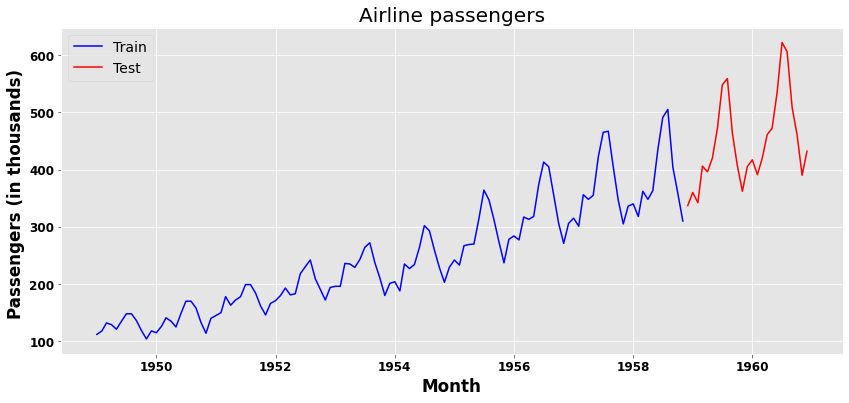

In [8]:
# set plot style to ggplot2
plt.style.use('ggplot')
# maximize the size of the labels, ticks, and figures
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 14
plt.tick_params(labelsize=12)

# plot the train and test sets 
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='red')
plt.legend()

# set the x-axis limits to show the full range of the data
# plt.xlim(left=1, right=len(df))

# set label properties
plt.title("Airline passengers")
plt.setp(plt.gca().get_xticklabels(), color='black', weight='bold')
plt.setp(plt.gca().get_yticklabels(), color='black', weight='bold')
plt.xlabel('Month', color='black', weight='bold')
plt.ylabel('Passengers (in thousands) ', color='black', weight='bold')

# show the plot
plt.show()

* The series has trend and seasonal effect and variability increases over indicating a multiplicative effect

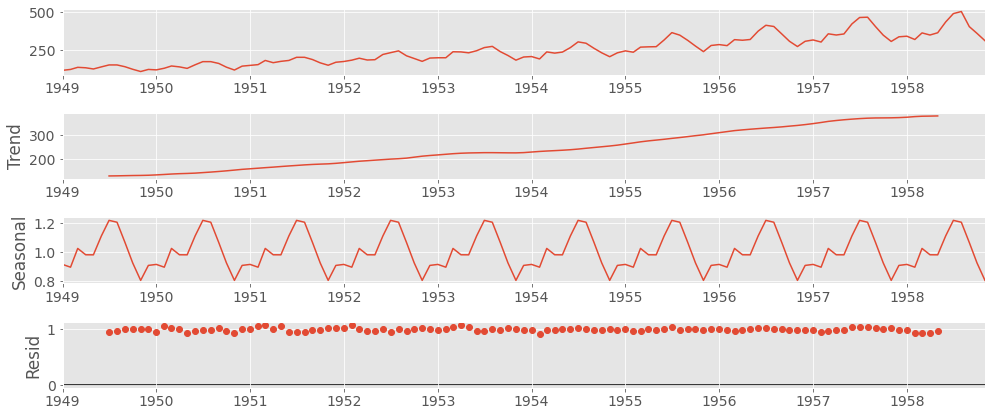

In [ ]:
seasonal_decomp = seasonal_decompose(train, model="multiplicative")
seasonal_decomp.plot();

In [ ]:
seasonal_decomp.trend

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1958-07-01   NaN
1958-08-01   NaN
1958-09-01   NaN
1958-10-01   NaN
1958-11-01   NaN
Freq: MS, Name: trend, Length: 119, dtype: float64

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


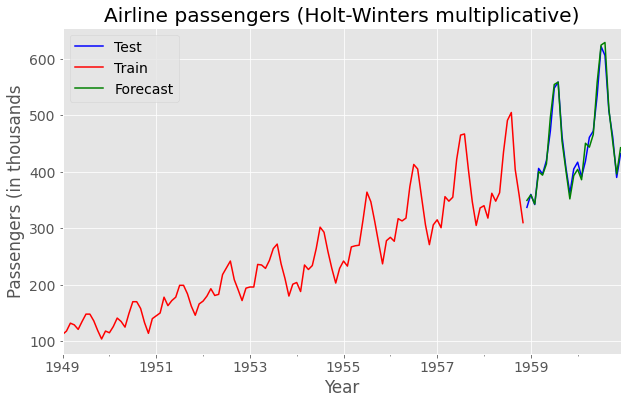

In [ ]:
# fit the Holt-Winters model with multiplicative seasonality
model_holt_winters = ExponentialSmoothing(train,
                                          trend='mul',
                                          seasonal='mul',
                                          seasonal_periods=12).fit(optimized=True)


# make predictions for the next 12 months
forecasts_holt_winters = model_holt_winters.forecast(len(test))


# plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 6))

test.plot(ax=ax, color='blue')
train.plot(ax=ax, color='red')
forecasts_holt_winters.plot(ax=ax, color='green')

ax.set_title("Airline passengers (Holt-Winters multiplicative)")
ax.set_xlabel('Year')
ax.set_ylabel('Passengers (in thousands')
ax.legend(['Test', 'Train', 'Forecast'])

# show the plot
plt.show()

In [ ]:
print(model_holt_winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                  119
Model:             ExponentialSmoothing   SSE                          10658.573
Optimized:                         True   AIC                            566.905
Trend:                   Multiplicative   BIC                            611.371
Seasonal:                Multiplicative   AICC                           573.745
Seasonal Periods:                    12   Date:                 Sun, 19 Feb 2023
Box-Cox:                          False   Time:                         08:36:46
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3906947                alpha                 True
smoothing_trend          

In [ ]:
#Evaluation metrics
print(f"MAE = {mean_absolute_error(test['Passengers'].values,forecasts_holt_winters.values)}")
print(f"RMSE = {np.sqrt(mean_squared_error(test['Passengers'].values,forecasts_holt_winters.values))}")
print(f"MAPE = {mape(test['Passengers'].values,forecasts_holt_winters.values)}")

MAE = 9.784245694940394
RMSE = 12.705082976079849
MAPE = 2.1884364578477293


# Decompose the series into Trend, Seasonal and white noise components

In [ ]:
# seasonally adjusted
single_ma  = train.rolling(12, center=True).mean()
double_ma = single_ma.rolling(2, center=False).mean()

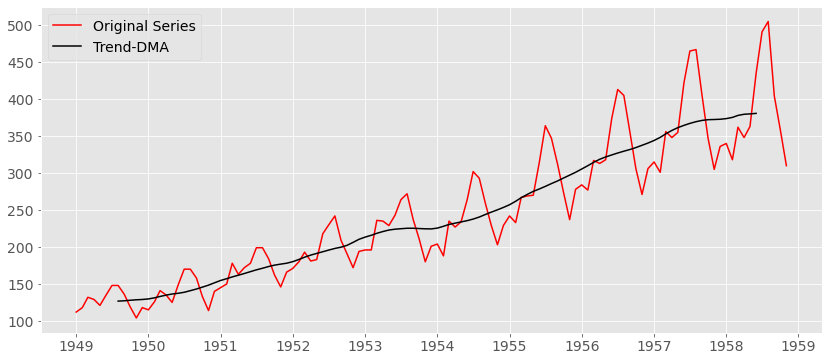

In [ ]:
plt.plot(train, color='red')
plt.plot(double_ma, color='black')
plt.legend(['Original Series',"Trend-DMA"])

In [ ]:
# seasonal variations in the series (seasonal indices)
# obtain an estimate of the combined seasonaland irregular components S * I
seasonal_ratio = pd.concat([train,(train/double_ma)], axis=1)
# eliminate the irregulae component
seasonal_indices =seasonal_ratio.groupby(train.index.month).mean()
# correct the seasonal indices as the total seasonal indices should equal the entire period seasonality was observed
scaled_seasonal_index_corr1 = seasonal_indices.iloc[:,-1] * (12/seasonal_indices.iloc[:,-1].sum())
scaled_seasonal_index_corr2  = scaled_seasonal_index_corr1 *(12/scaled_seasonal_index_corr1.sum())
print(f'The total correcated scaled seasonal index {scaled_seasonal_index_corr2.sum()}')
# Reshape the seasonal indices into a 1D array
scaled_seasonal_index_corr2 = np.tile(scaled_seasonal_index_corr2, 12).reshape(-1)
# Generate the new index
sea_index = pd.date_range(start='1949-01-01', end=test.index[-1], freq='MS')

scaled_seasonal_index_corr2 = pd.Series(scaled_seasonal_index_corr2, index=sea_index)
deseasonalized_values = train.squeeze().values/scaled_seasonal_index_corr2[:-25] # Yt/corrected seasonal indices

The total correcated scaled seasonal index 12.000000000000004


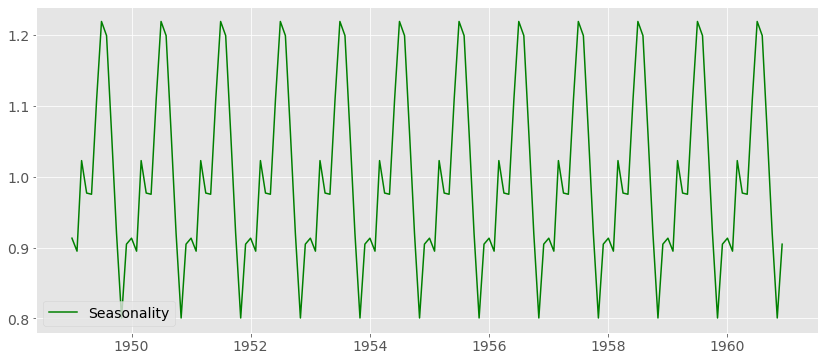

In [ ]:
plt.plot(scaled_seasonal_index_corr2, color='green')
# plt.plot(residuals, color='blue')
plt.legend(["Seasonality",'Residuals'])

In [ ]:
# calculate residuals
residuals = train.values.ravel()/(double_ma.values.ravel()*scaled_seasonal_index_corr2.values[:-25])
res_index = pd.date_range(start=double_ma.index[0], end=double_ma.index[-1], freq='MS')
residuals = pd.Series(residuals, index=res_index)

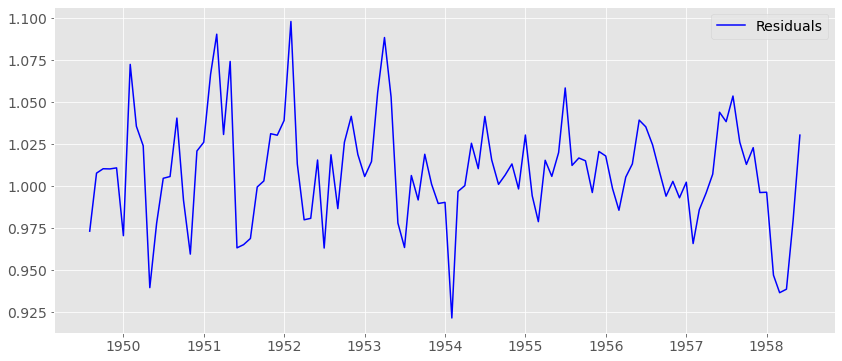

In [ ]:
plt.plot(residuals, color='blue')
plt.legend(['Residuals'])

# Forecasting each component individually

In [ ]:
# # Define the forecast horizon for residuals and initialize the forecast
# horizon = 30
# forecast_residuals = residuals.dropna().copy()
# forecast_residuals = forecast_residuals[-30:]
# forecast_residuals  = forecast_residuals.to_numpy()


# # # Iterate over the forecast horizon and calculate the forecast for each period
# for i in range(0, horizon):
#     forecast_residuals = np.append(forecast_residuals, np.mean(forecast_residuals[-30:]))
# # # Generate the new index
# fore_resi_idx = pd.date_range(start='1958-06-02', end=test.index[-1], freq='MS')
# forecast_residuals = pd.Series(forecast_residuals[-30:], index=fore_resi_idx)

In [ ]:
# optimize the double exponential smoothing

alpha_values = np.arange(0,1,0.01)
beta_values = np.arange(0,1,0.01)

results = []
for alpha in alpha_values:
    for beta in beta_values:
        # fit the model
        model = Holt(deseasonalized_values).fit(smoothing_level=alpha, smoothing_slope=beta)
    
        # make the forecast
        forecast_deseasonalized_values = model.forecast(steps=25)

        #Final forecast for multiplicative series-> Yt = Yt = Tt * St* It -> trend * seasonality * random variations
        # deseasonalized_values =  Tt * It 
        Yt =  forecast_deseasonalized_values * scaled_seasonal_index_corr2[-25:] 
    
        # compute the MSE
        mse = ((Yt - test.squeeze()) ** 2).mean()
    
        # # store the results
        results.append({'alpha': alpha, 'beta': beta, 'mse': mse})
results = pd.DataFrame(results, columns=['alpha','beta','mse'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-187-d271f0dd35ff>:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model = Holt(deseasonalized_values).fit(smoothing_level=alpha, smoothing_slope=beta)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [ ]:
# find the optimal alpha and beta values
results.loc[results['mse'] == results['mse'].min()]

,alpha,beta,mse
1461,0.14,0.61,394.813912


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-194-8ae453e09b44>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model = Holt(deseasonalized_values).fit(smoothing_level = 0.14	, smoothing_slope = 0.61)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


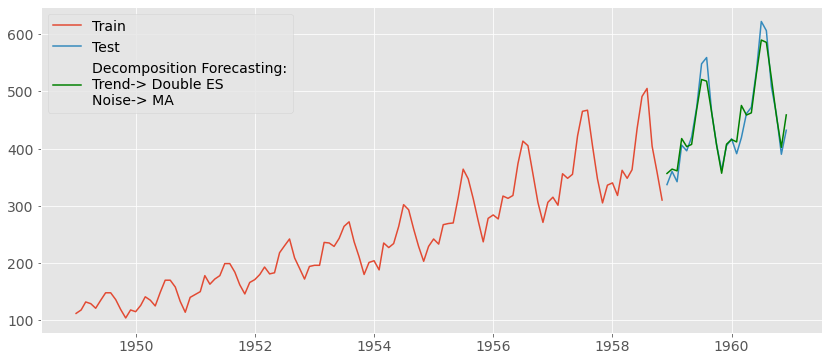

In [ ]:
# fit the best model
model = Holt(deseasonalized_values).fit(smoothing_level = 0.14	, smoothing_slope = 0.61)

# make the forecast
forecast_deseasonalized_values  = model.forecast(steps=25)

#Final forecast for multiplicative series-> Yt = Yt = Tt * St* It -> trend * seasonality * random variations
# deseasonalized_values =  Tt * It 
Yt =  forecast_deseasonalized_values * scaled_seasonal_index_corr2[-25:] 

# compute the MSE
mse = ((Yt - test.squeeze()) ** 2).mean()

# plot the forecast and the original data
 # compute the MSE
# print(f'mse: {((Yt.values - test.squeeze().values) ** 2).mean()}')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(Yt, label='ETS Decomposition Forecasting', color='green')
plt.legend()
plt.show()

In [ ]:
#Evaluation metrics
print(f"MAE = {mean_absolute_error(Yt.values , test.squeeze().values)}")
print(f"RMSE = {np.sqrt(mean_squared_error(Yt.values, test.squeeze().values))}")
print(f"MAPE = {mape(Yt.values, test.squeeze().values)}")

MAE = 14.380339349445501
RMSE = 19.86992482040352
MAPE = 3.1140423583079078


# Trend line projection

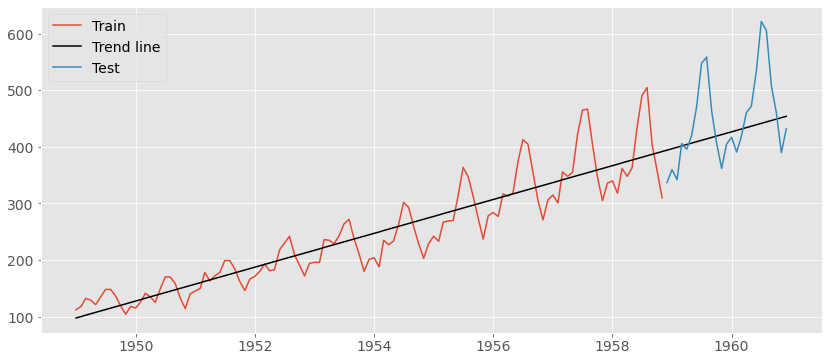

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# create a time variable
train_time = np.arange(1, len(deseasonalized_values)+1)
train_constant = np.ones((len(train)))
train_predictors = np.stack((train_constant, train_time), axis=1)

# Create a linear regression object and add a constant
lr = LinearRegression()

y = deseasonalized_values.values.reshape(-1,1)

# Fit the model using the training data
lr.fit(train_predictors, y)

# Make a prediction for entire series
series_time =  np.arange(1, len(df)+1)
series_constant = np.ones((len(df)))
series_predictors = np.stack((series_constant , series_time ), axis=1)

# predictors = np.stack((constant, test_time_data), axis=1)
trend_line_projection = lr.predict(series_predictors)
series_index = pd.date_range(start=df.index[0], end=df.index[-1], freq='MS')

trend_line_projection = pd.Series(trend_line_projection.ravel(), index=series_index)
# deseasonalized_values_plot = pd.Series(deseasonalized_values, index=series_index)

# plt.plot(lr.)
plt.plot(train, label='Train')
plt.plot(trend_line_projection, label='Trend line', color='black')
plt.plot(test, label ='Test')
plt.legend()
plt.show()
# plt.plot(trend_line_projection*scaled_seasonal_index_corr2, fi)

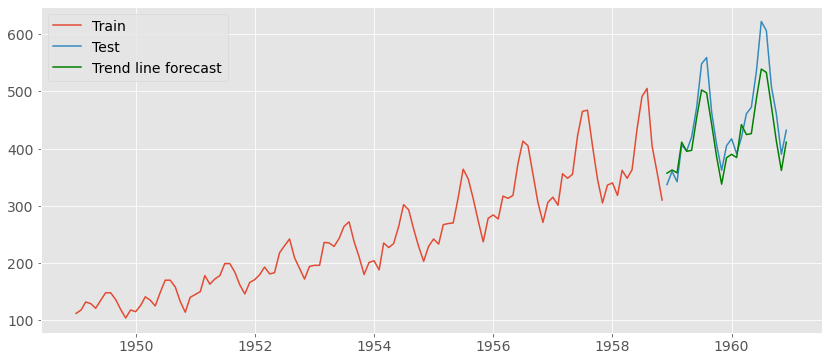

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label ='Test')
Yt_trend_line = trend_line_projection[-25:] *scaled_seasonal_index_corr2[-25:] 
plt.plot(Yt_trend_line, label='Trend line forecast', color='green')
plt.legend()
plt.show()

In [ ]:
#Evaluation metrics
print(f"MAE = {mean_absolute_error(Yt_trend_line.values , test.squeeze().values)}")
print(f"RMSE = {np.sqrt(mean_squared_error(Yt_trend_line.values , test.squeeze().values))}")
print(f"MAPE = {mape(Yt_trend_line.values , test.squeeze().values)}")

MAE = 30.144770499570477
RMSE = 36.48963048215188
MAPE = 6.8000701411540065


# ARIMA Modeling

In [459]:
# train_log = np.log(train)
train_trend_diff = train.diff(1).dropna()
train_seasoanl_diff = train_trend_diff.diff(12)
train_seasoanl_diff.dropna(inplace=True)

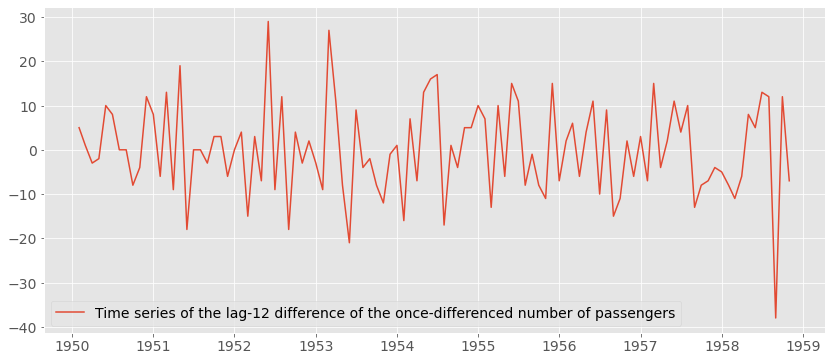

In [471]:
plt.plot(train_seasoanl_diff, label='Time series of the lag-12 difference of the once-differenced number of passengers')
plt.legend()
plt.show()

In [463]:
#Check for stationarity
result = sm.tsa.stattools.adfuller(train_seasoanl_diff, autolag= 'AIC')
if result[1] < 0.05:
    print('Time series is stationary')
else:
    print('Time series is not stationary')

Time series is stationary


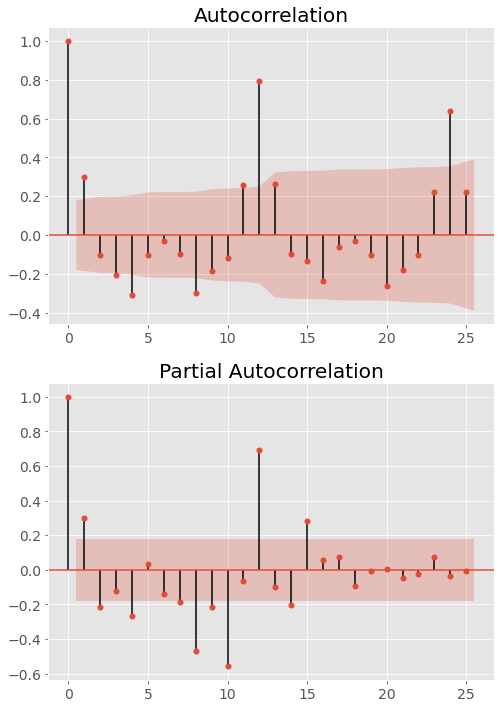

In [464]:
fig, ax = plt.subplots(2, figsize=(8,12))
sm.graphics.tsa.plot_acf(train_trend_diff, lags=25, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_trend_diff, lags=25, ax=ax[1])
plt.show()

In [ ]:
pip install pmdarima

In [402]:
# Fit the model using auto_arima
model = pm.auto_arima(train, 
                      test='adf',       # use the ADF test to find best order of integration
                      max_p=2, max_q=2, # maximum p and q
                      m=12,             # frequency of series (12 for monthly data)
                      d=None,           # let model determine order of integration
                      seasonal=True,    # allow for seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='aic' # Select based on BIC
                     )

# Print the model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=800.975, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=798.158, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=798.620, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=796.494, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=798.234, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=798.255, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=797.825, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=796.886, Time=0.14 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=799.807, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=798.494, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 4.500 seconds
                                     SARIMAX Results                                      
Dep.

In [419]:
p, d, q = 1, 1, 0
P, D, Q, m = 0, 1, 0, 12

In [422]:
model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m),
                                  enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  119
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -392.864
Date:                            Tue, 21 Feb 2023   AIC                            789.727
Time:                                    08:38:26   BIC                            795.035
Sample:                                01-01-1949   HQIC                           791.878
                                     - 11-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2449      0.092     -2.652      0.008      -0.426      -0.064
sigma2       104.0882     12.727   

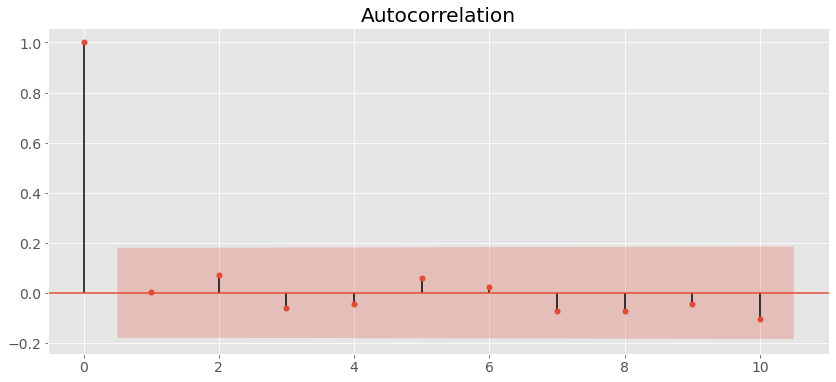

Residuals are white noise


/usr/local/lib/python3.8/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  -----


In [405]:
# plot residuals
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(results.resid, lags=10, ax=ax)
plt.show()

# perform Ljung-Box test
lbvalue, pvalue = sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=10)
if pvalue.min() < 0.05:
    print('Residuals are not white noise')
else:
    print('Residuals are white noise')

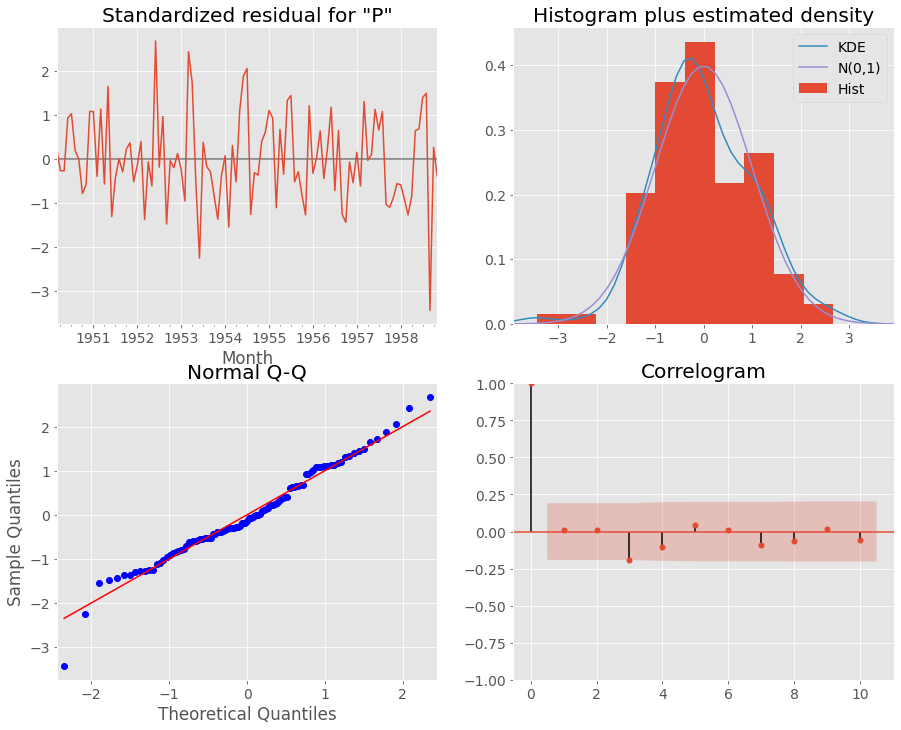

In [423]:
# Perform diagnostic tests on the residuals
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [457]:
#out-of-sample forecasting
forecast_values = results.forecast(steps=len(test))

In [432]:
#prediction summary
forecast_values.summary_frame()

Passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1958-12-01,342.714249,10.202362,322.717987,362.710511
1959-01-01,346.294442,12.784284,321.237705,371.351179
1959-02-01,324.397249,15.250883,294.506068,354.288431
1959-03-01,368.372073,17.299461,334.465753,402.278392
1959-04-01,354.378238,19.145597,316.853558,391.902918
1959-05-01,369.376728,20.825203,328.560081,410.193375
1959-06-01,441.377098,22.379909,397.513283,485.240914
1959-07-01,497.377008,23.833228,450.664739,544.089276
1959-08-01,511.377030,25.202923,461.980208,560.773852
1959-09-01,410.377024,26.501913,358.434229,462.319820


In [458]:
#Evaluation metrics
print(f"MAE = {mean_absolute_error(forecast_values.values , test.squeeze().values)}")
print(f"RMSE = {np.sqrt(mean_squared_error(forecast_values.values , test.squeeze().values))}")
print(f"MAPE = {mape(forecast_values.values , test.squeeze().values)}")

MAE = 58.9938205863988
RMSE = 65.36220775829106
MAPE = 15.108860193875708


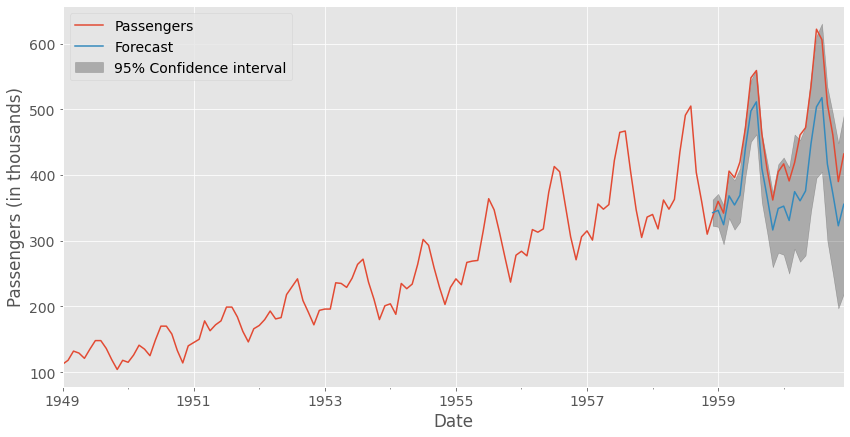

In [452]:
pred_uc = results.get_forecast(steps=len(test))
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25, label='95% Confidence interval')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (in thousands)')

plt.legend(loc ='upper left')
plt.show()